# UC Irvine Diabetes Dataset 1999-2008

## Background and Objective

The dataset used here represents 10 years (1999 - 2008) of clinical care related to inpatient diabetes treatment at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the Health Facts database (Cerner Corporation, Kansas City, MO), a national data warehouse that collects comprehensive clinical records across hospitals throughout the United States. 

My objective in analyzing this dataset is to see if I can duplicate results from the 2014 paper listed in the References section below.  In particular, I will train a logistic regression model to predict whether a patient will be readmitted within 30 days of discharge.  


## References

1.  https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
2.  Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014. 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ggplot import *
import sklearn as sk
from sklearn_pandas import DataFrameMapper, cross_val_score

pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

In [3]:
df_raw = pd.read_csv('diabetic_data.csv')
df_raw_IDs = pd.read_csv('IDs_mapping.csv')

In [4]:
df_raw_IDs

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


In [5]:
df_raw.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df_raw.columns.values

array(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
       'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'], dtype=object)

In [7]:
len(df_raw.columns)

50

This is odd.  The paper and the UCI website for this dataset both say there are 55 attributes but I only count 50.  Counting by hand I get 50 also.  Strange.  I read table in paper and they made some errors.  They say 55 in the paper, but I only counted 50.  Also, they say they tracked 24 meds when they only tracked 23.  So there is the discrepancy.  The paper is wrong.

In [8]:
df_raw.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [9]:
len(df_raw)

101766

Well at least this makes sense.  Paper says they filtered to 101,766 records.  

In [10]:
df_raw[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
        'number_outpatient','number_emergency','number_inpatient',
        'number_diagnoses']].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


This is insane!  A mean of 16 meds per patient????  43 lab procedures!!???  Really?  Sounds like polypharmacy to me.

{'boxes': [<matplotlib.lines.Line2D at 0x103b41c90>,
 'caps': [<matplotlib.lines.Line2D at 0x10a33fb90>,
 'fliers': [<matplotlib.lines.Line2D at 0x103afbb90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x103afbcd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x103b41e90>,
  <matplotlib.lines.Line2D at 0x10a350d50>]}

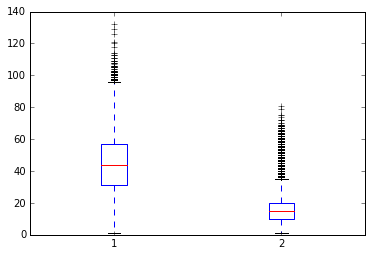

In [11]:
plt.boxplot([df_raw['num_lab_procedures'], df_raw['num_medications']])

So does this data set contain multiple visits per patient?  Let's find out.

In [12]:
len(np.unique(df_raw['patient_nbr']))

71518

So 101766 total entries, but only 71518 unique patients.  

/Users/jonneff/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


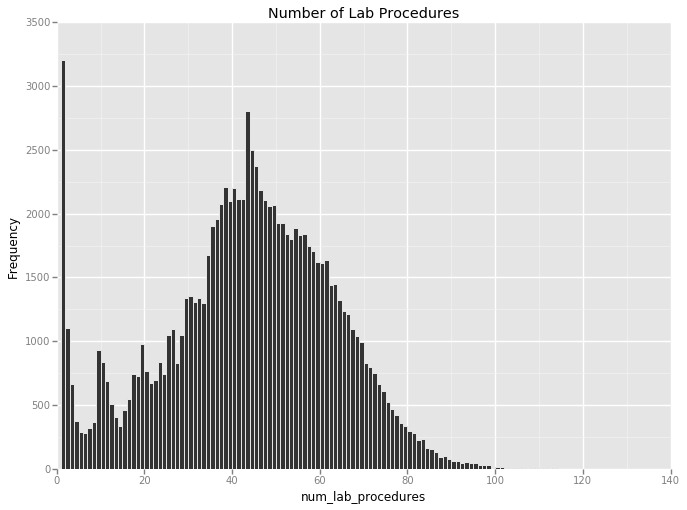

<ggplot: (272308917)>

In [13]:
ggplot(df_raw, aes(x = 'num_lab_procedures')) + geom_histogram(binwidth = 1) + ggtitle(
"Number of Lab Procedures") + ylab('Frequency')

This looks vaguely Gaussian to me, although there are a lot of entries with zero or one lab procedures.

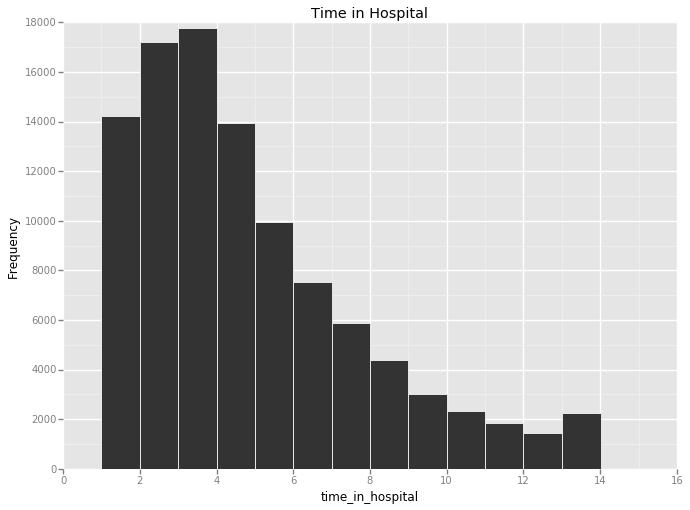

<ggplot: (280575537)>

In [14]:
ggplot(df_raw, aes(x = 'time_in_hospital')) + geom_histogram(binwidth = 1) + ggtitle(
"Time in Hospital") + ylab('Frequency')

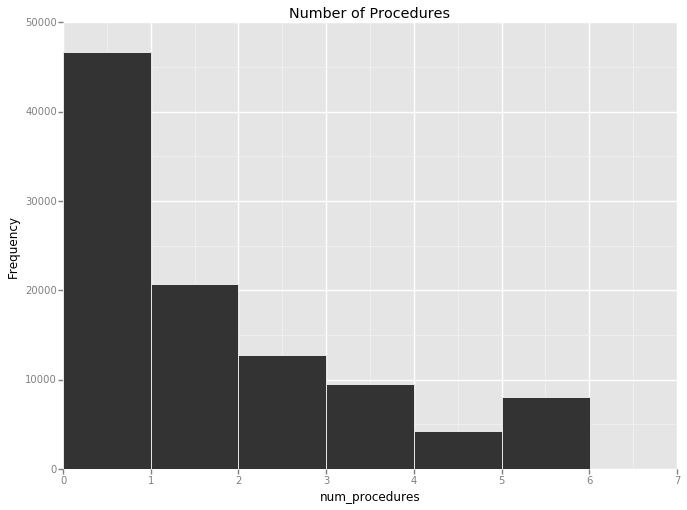

<ggplot: (280582525)>

In [15]:
ggplot(df_raw, aes(x = 'num_procedures')) + geom_histogram(binwidth = 1) + ggtitle(
"Number of Procedures") + ylab('Frequency')

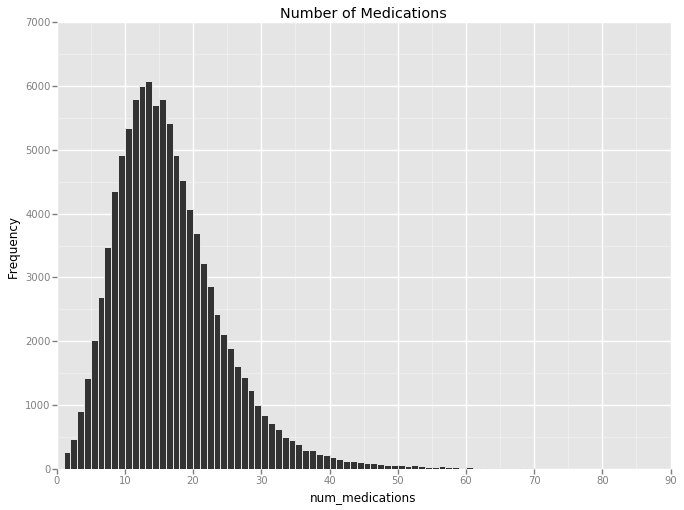

<ggplot: (281562181)>

In [16]:
ggplot(df_raw, aes(x = 'num_medications')) + geom_histogram(binwidth = 1) + ggtitle(
"Number of Medications") + ylab('Frequency')

Number of meds looks vaguely Poisson-ish to me.  Poisson is often used to model number of occurences of an event in a particular time period or space if the events have an average rate and are independent.

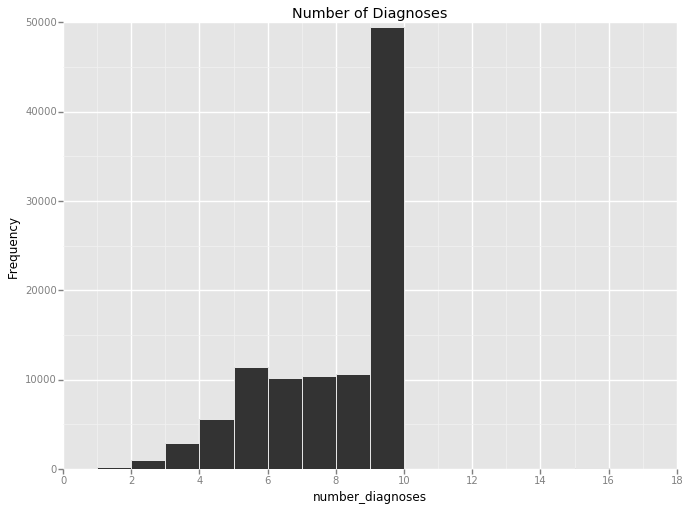

<ggplot: (282450913)>

In [17]:
ggplot(df_raw, aes(x = 'number_diagnoses')) + geom_histogram(binwidth = 1) + ggtitle(
"Number of Diagnoses") + ylab('Frequency')

Wow.  These people have a lot of things wrong with them.  Diabetes is only one part.  

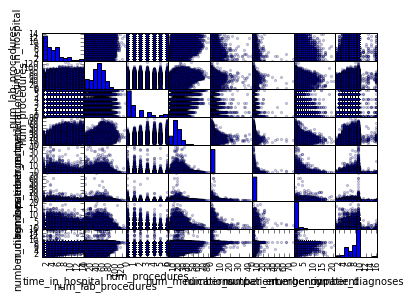

In [18]:
df_raw_nums = df_raw[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
        'number_outpatient','number_emergency','number_inpatient',
        'number_diagnoses']]
axes = pd.tools.plotting.scatter_matrix(df_raw_nums, alpha=0.2)
# plt.tight_layout()

Need to work on this one.  pairs() in R is much cleaner.  

OK in paper they remove duplicate patient records, keeping the first so they have independent events, a precondition for logistic regression.  

In [19]:
df_drop = df_raw.drop_duplicates(subset = 'patient_nbr', keep = 'first')

In [20]:
df_drop.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [21]:
len(df_drop)

71518

From paper, remove all encounters that resulted in either discharge to a hospice or patient death, to avoid biasing our analysis. 

In [26]:
df_final = df_drop[(df_drop['discharge_disposition_id'] != 11) &
                   (df_drop['discharge_disposition_id'] != 13) &
                   (df_drop['discharge_disposition_id'] != 14) &
                   (df_drop['discharge_disposition_id'] != 19) &
                   (df_drop['discharge_disposition_id'] != 20) &
                   (df_drop['discharge_disposition_id'] != 21) 
                  ]

In [27]:
len(df_final)

69973

Paper said 69,984.  I must have excluded some stuff ("expired at home") that they included.  Go figure.

Now calculate fraction of cases where A1C blood test was performed.  Paper says 18.4%.  

In [28]:
num_A1C = len(df_final[(df_final['A1Cresult'] != 'None')])

In [29]:
num_A1C

12845

In [30]:
float(num_A1C) / float(len(df_final))

0.18357080588226887

Sounds about right.  

Now we get into some meat in the paper, and I quote:

"After preliminary analysis and taking into account the amount of data, the significance level was determined by a 𝑃 value of less than 0.01.

Multivariable logistic regression was used to fit the relationship between the measurement of HbA1c and early readmission while controlling for covariates such as demo- graphics, severity and type of the disease, and type of admission.
To assess whether the candidate covariates were signifi- cantly associated with readmission, we created the model in four steps. Each step was followed by tests for significance of variables with higher degree of freedom, an analysis of deviance table, and sensitivity analysis which was done by removing one variable at the time and looking at changes of beta-coefficients.

First, we fitted a logistic model with all variables but HbA1c. We refer to this model as the core model. Second, we added HbA1c to the core model. Third, we added pairwise interactions to the core model (without HbA1c) and kept only the significant ones. Finally, we added pairwise interactions with HbA1c, leaving only the significant ones in the final model.
Graphics were used to help in the interpretation of inter- action terms in the final model. The analysis was performed in R statistical software."

There's a lot going on here.  They did logistic regression without A1c.  Then they added A1c.  Then they added pairwise interactions: x1*x2, x2*x3, etc.  Why?  Examining pairwise interactions is common in biostatistics.  What if A is good for the patient, and B is good, but the combination of A and B is worse than either A or B alone?  That's why.    

So the authors are trying to account for complex interactions between the features.  At least, they are creating models with x1x2 features one at a time and then keeping them if they result in a significantly better model.  

This link gives a pretty good explanation of analysis of deviance and how you use it to pick the best model.  An important point is that the models being compared have to be "nested," i.e., each model is a superset of the model below it.  https://onlinecourses.science.psu.edu/stat504/node/157

Analysis of deviance is the logistic regression equivalent of analysis of variance (ANOVA) for linear regression models. Deviance D for a model is defined as:

<img src="deviance_equation.png">

Theta-hat-0 are the fitted model parameters, while theta-hat-s are the parameters for the "saturated model."
So the "saturated model" is the model that is an exact fit to the data, i.e., something like an overfitted spline.  

So we are ultimately trying to predict whether a patient will be readmitted within 30 days based on a set of features, including pairwise features.  From the paper:

"The significant pairwise interactions between the covari- ates were  were discharge disposition with race (𝑃 < 0.001), medical specialty of the admitting physician (𝑃 = 0.001), primary diagnosis (𝑃 = 0.005), and time in hospital (𝑃 < 0.001); the specialty of the admitting physician with time in hospital (𝑃 = 0.001) and age (𝑃 < 0.001); and the primary diagnosis with time in the hospital (𝑃 < 0.001) and HbA1c (𝑃 = 0.004). Only these interactions were included in the final model.